In [1]:
# import drive
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# set path
import os
os.chdir('/content/drive/MyDrive/mlmed2025')

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

Load data

In [39]:
df_train = pd.read_csv('mitbih_train.csv')
df_test = pd.read_csv('mitbih_test.csv')

In [27]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87553 entries, 0 to 87552
Columns: 188 entries, 0 to target
dtypes: float64(188)
memory usage: 125.6 MB


In [40]:
# the data dont have name for the columns, so add them
# from column 0 to 187 are the values of the ECG signal
# the last column is the label of the signal
df_train.columns = [str(i) for i in range(188)]
df_train = df_train.rename(columns={df_train.columns[-1]: 'target'})
df_test.columns = [str(i) for i in range(188)]
df_test = df_test.rename(columns={df_test.columns[-1]: 'target'})

EDA

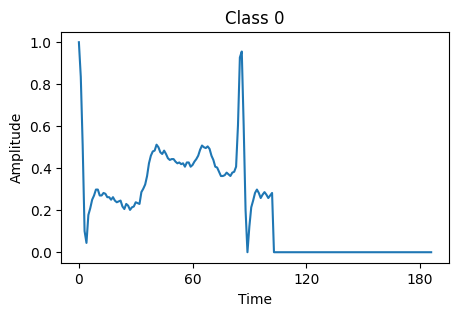

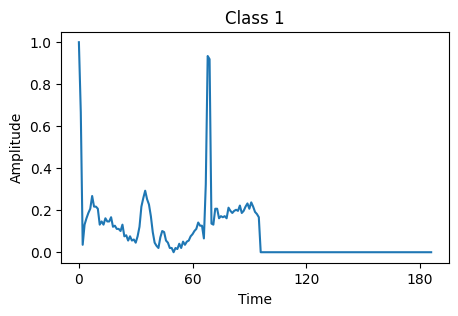

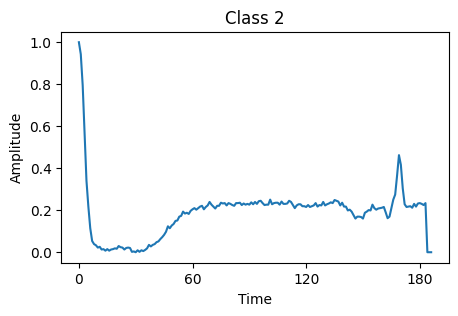

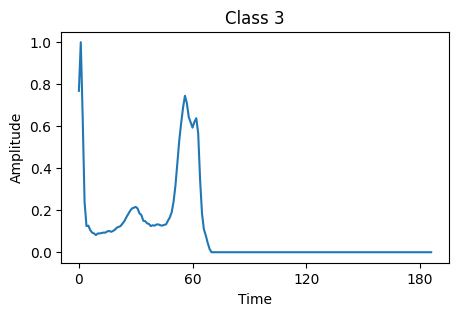

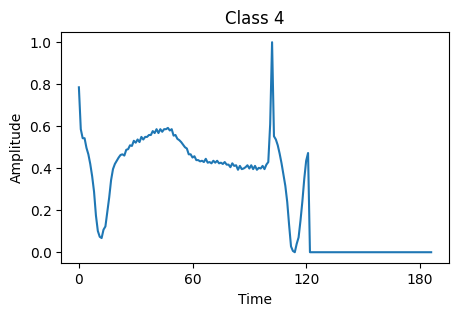

In [6]:
# draw 1 sample of each class in target
for i in range(5):
    fig, ax = plt.subplots(figsize=(5, 3))
    sample = df_train[df_train['target'] == i].sample(1)
    ax.plot(sample.iloc[:, :-1].values[0])
    ax.set_title(f'Class {i}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude')
    ax.set_xticks(range(0,181,60))
    plt.show()

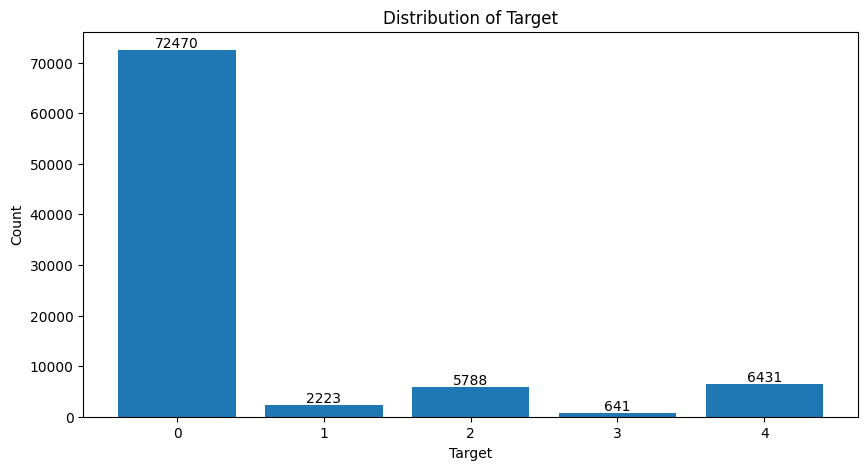

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

values = df_train['target'].value_counts().index
counts = df_train['target'].value_counts().values

plt.figure(figsize=(10, 5))
bars = plt.bar(values, counts)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, round(yval, 2), ha='center', va='bottom')

plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Distribution of Target')
plt.show()

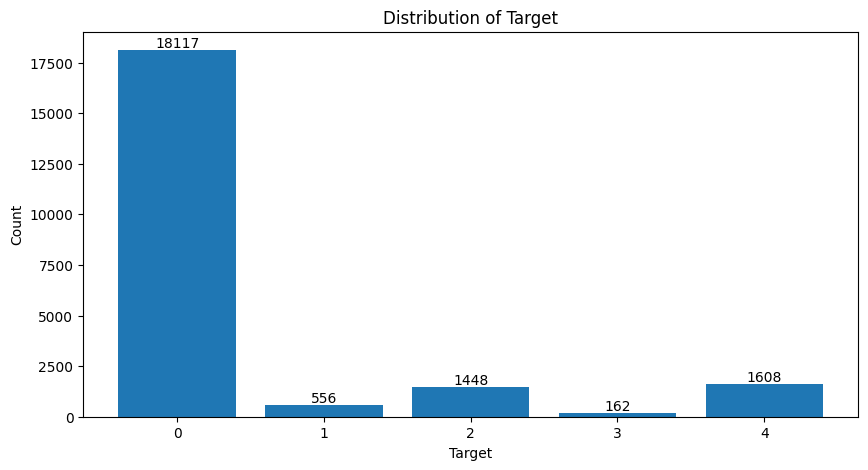

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

values = df_test['target'].value_counts().index
counts = df_test['target'].value_counts().values

plt.figure(figsize=(10, 5))
bars = plt.bar(values, counts)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, round(yval, 2), ha='center', va='bottom')

plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Distribution of Target')
plt.show()

Prepocessing

In [ ]:
from sklearn.utils import resample

def balance_dataset(df, target_column, n_samples):
    classes = df[target_column].unique()

    balanced_dfs = []

    for cls in classes:
        df_class = df[df[target_column] == cls]

        if len(df_class) > n_samples:
            # Undersample the majority class
            df_class_balanced = df_class.sample(n=n_samples, random_state=42)
        else:
            # Oversample the minority class
            df_class_balanced = resample(df_class, replace=True, n_samples=n_samples, random_state=42)

        balanced_dfs.append(df_class_balanced)

    # Combine and shuffle 
    df_balanced = pd.concat(balanced_dfs)
    df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

    return df_balanced

df_train_balanced = balance_dataset(df_train, 'target', 4000)
df_test_balanced = balance_dataset(df_test, 'target', 162)

In [51]:
# Prepare the data
X_train = df_train_balanced.drop('target', axis=1).values
y_train = df_train_balanced['target'].values
X_test = df_test_balanced.drop('target', axis=1).values
y_test = df_test_balanced['target'].values

In [52]:
# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape the data for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [53]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((20000, 187, 1), (810, 187, 1), (20000,), (810,))

In [54]:
# Convert labels to categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

Training

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Build LSTM model
model = Sequential()

model.add(LSTM(128, kernel_regularizer=l2(0.001), return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(64, kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))

model.add(Dense(5, activation='softmax'))  # 5 classes

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

In [ ]:
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

Epoch 1/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 200s 313ms/step - accuracy: 0.2317 - loss: 1.7885 - val_accuracy: 0.3309 - val_loss: 1.4933 - learning_rate: 1.0000e-04
Epoch 2/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 195s 312ms/step - accuracy: 0.3993 - loss: 1.5163 - val_accuracy: 0.4691 - val_loss: 1.3362 - learning_rate: 1.0000e-04
Epoch 3/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 195s 312ms/step - accuracy: 0.4828 - loss: 1.3744 - val_accuracy: 0.5049 - val_loss: 1.2859 - learning_rate: 1.0000e-04
Epoch 4/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 200s 309ms/step - accuracy: 0.5038 - loss: 1.3045 - val_accuracy: 0.5099 - val_loss: 1.2381 - learning_rate: 1.0000e-04
Epoch 5/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 200s 306ms/step - accuracy: 0.5245 - loss: 1.2652 - val_accuracy: 0.5284 - val_loss: 1.2027 - learning_rate: 1.0000e-04
Epoch 6/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 202s 307ms/step - accuracy: 0.5419 - loss: 1.2008 - val_accuracy: 0.5617 - val_loss: 1.1844 - learning_rate: 1.0000e-04
Epoch 7/200
625/625 ━━━━━━━━━━━━━━

In [59]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.8442 - loss: 0.4960
Loss: 0.4942431151866913
Accuracy: 0.8469135761260986


26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step


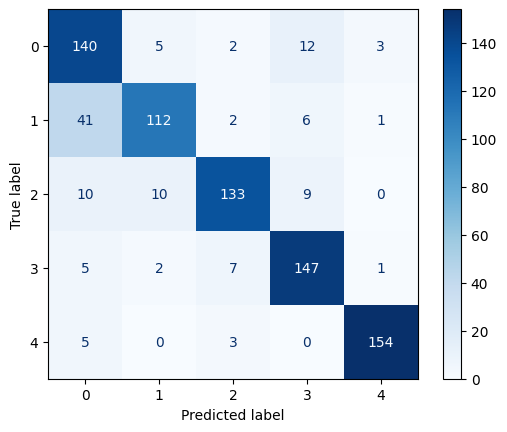

F1 Score: 0.8472904588022787
Precision: 0.8565754834574375
Recall: 0.8469135802469135


In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# others metrics
f1 = f1_score(y_true, y_pred_classes, average='weighted')
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')

print(f'F1 Score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

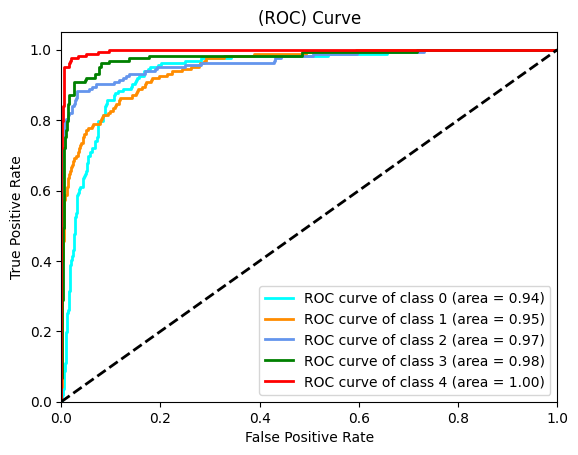

In [ ]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curve')
plt.legend(loc="lower right")
plt.show()